In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup             
from nltk.corpus import stopwords # Import the stop word list
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from sklearn.model_selection import train_test_split
from keras.models import load_model

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submit_template = pd.read_csv('../input/sample_submission.csv', header = 0)

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
list_sentences = train["comment_text"]
list_sentences_test = test["comment_text"]

In [5]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features,char_level=True)

In [6]:
tokenizer.fit_on_texts(list(list_sentences))

In [7]:
list_tokenized = tokenizer.texts_to_sequences(list_sentences)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [8]:
maxlen = 500
X_t = pad_sequences(list_tokenized, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Just in case you are wondering, the reason why I used 500 is because most of the number of characters in a sentence falls within 0 to 500:

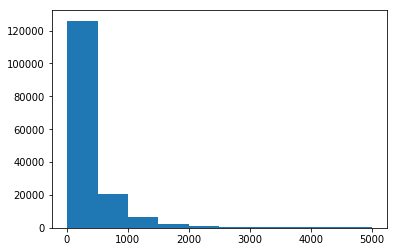

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized]
plt.hist(totalNumWords)
plt.show()

Finally, we can start buliding our model.

First, we set up our input layer. As mentioned in the Keras documentation, we have to include the shape for the very first layer and Keras will automatically derive the shape for the rest of the layers.

In [10]:
inp = Input(shape=(maxlen, ))
inp

<tf.Tensor 'input_1:0' shape=(?, 500) dtype=float32>

In [11]:
embed_size = 240
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)

In [12]:
x = Conv1D(filters=100,kernel_size=4,padding='same', activation='relu')(x)

Then we pass it to the max pooling layer that applies the max pool operation on a window of every 4 characters. And that is why we get an output of (num of sentences X 125 X 100) matrix.

In [13]:
x=MaxPooling1D(pool_size=4)(x)

In [14]:
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)

In [15]:
x = GlobalMaxPool1D()(x)

In [16]:
x = Dense(50, activation="relu")(x)

In [17]:
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

In [18]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 240)          507600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 100)          96100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 125, 120)          57960     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
__________

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_t, train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]], test_size = 0.10, random_state = 42)

In [21]:
batch_size = 32
epochs = 6
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_test,y_test),verbose=2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/6
 - 2352s - loss: 0.0788 - acc: 0.9764 - val_loss: 0.0579 - val_acc: 0.9808
Epoch 2/6
 - 2347s - loss: 0.0581 - acc: 0.9806 - val_loss: 0.0507 - val_acc: 0.9820
Epoch 3/6
 - 2359s - loss: 0.0531 - acc: 0.9816 - val_loss: 0.0482 - val_acc: 0.9828
Epoch 4/6
 - 2296s - loss: 0.0505 - acc: 0.9821 - val_loss: 0.0476 - val_acc: 0.9827
Epoch 5/6
 - 2223s - loss: 0.0491 - acc: 0.9824 - val_loss: 0.0481 - val_acc: 0.9830
Epoch 6/6
 - 2212s - loss: 0.0481 - acc: 0.9827 - val_loss: 0.0458 - val_acc: 0.9833


In [22]:
y_submit = model.predict(X_te,batch_size=batch_size,verbose=1)

153164/153164 [==============================] - 900s 6ms/step


In [23]:
y_submit[np.isnan(y_submit)]=0
sample_submission = submit_template
sample_submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_submit
sample_submission.to_csv('submission.csv', index=False)